In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# The approximate weight-matching algorihtm from Git-Rebasin

In [284]:
def approximate_weight_matching(model_A, model_B):
    """
    The weight-matching approach from Git Rebasin (algorithm 2). 
    A greedy coordinate descemt along permutation matricies of B w.r.t A
    where A and B are both weight sets of simple Neural Networks. 
    """
    for (name_A, param_A), (name_B, param_B) in zip(model_A.named_parameters(), model_B.named_parameters()):
        if 'weight' in name_A:
            distance_matrix = torch.cdist(param_A.T, param_B.T) # Distance between A and B
            row_ind, col_ind = torch.topk(-distance_matrix, k=16, dim=1) # Return the reverse order of A-B distance in A dims (16)
            sorted_B = torch.zeros_like(param_B) # Create placeholder B to repopulate
            for i, j in enumerate(col_ind[0]):
                sorted_B[:, i] = param_B[:, j] # Reshuffle B elements acording to greedy search in torch.topk()
            param_B.data = sorted_B

In [3]:
 # Define a simple neural network for MNIST digit classification with hidden layers of 16 units each
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 16)  # Input layer adjusted for 28x28 MNIST images
        # self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 10)  # Output layer for 10 classes (MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.layer1(x))
        # x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [5]:
# Load the MNIST dataset with necessary transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [9]:
# Training function for each model
def train_model(model, dataloader, criterion, optimizer, epochs=2):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Initialize two independent models
model_A = SimpleNN()
model_B = SimpleNN()

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=0.01)
optimizer_B = optim.SGD(model_B.parameters(), lr=0.01)

In [11]:
# Approximate weight matching algorithm to align model_B to model_A
def approximate_weight_matching(model_A, model_B):
    # For each layer, match weights from model B to model A
    for (name_A, param_A), (name_B, param_B) in zip(model_A.named_parameters(), model_B.named_parameters()):
        if 'weight' in name_A:
            # Use simple column swapping based on closest norm (greedy approach)
            distance_matrix = torch.cdist(param_A.T, param_B.T)
            row_ind, col_ind = torch.topk(-distance_matrix, k=16, dim=1)  # largest negative distance == smallest distance
            sorted_B = torch.zeros_like(param_B)
            for i, j in enumerate(col_ind[0]):
                sorted_B[:, i] = param_B[:, j]
            param_B.data = sorted_B


In [13]:
t = 10
# Train both models
train_model(model_A, train_loader, criterion, optimizer_A, epochs=t)
train_model(model_B, train_loader, criterion, optimizer_B, epochs=t)

In [14]:
# Track weights for visualization after multiple matching steps
weights_over_time = []

for step in range(10):  # Iterating over multiple alignment steps
    approximate_weight_matching(model_A, model_B)
    # Capture the weights as flattened tensors for visualization
    weights_over_time.append([param.detach().clone() for param in model_B.parameters()])

def tsne_visualize(weights_over_time):
    tsne = TSNE(n_components=2, perplexity=min(10, len(weights_over_time) - 1))  # Set perplexity based on sample count
    tsne_data = []
    
    # Flatten each step's weights into a single vector
    for weights in weights_over_time:
        flat_weights = np.concatenate([w.view(-1).numpy() for w in weights])
        tsne_data.append(flat_weights)
    
    # Convert list to a NumPy array for t-SNE
    tsne_data = np.array(tsne_data)
    tsne_result = tsne.fit_transform(tsne_data)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=np.arange(len(tsne_data)), cmap='viridis')
    plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], c='red', label="Model A", marker="X", s=50, alpha = 0.6)  # Model A as red X
    plt.colorbar(label='Time Steps')
    plt.title("t-SNE of Model B Weights Over Time")
    plt.show()


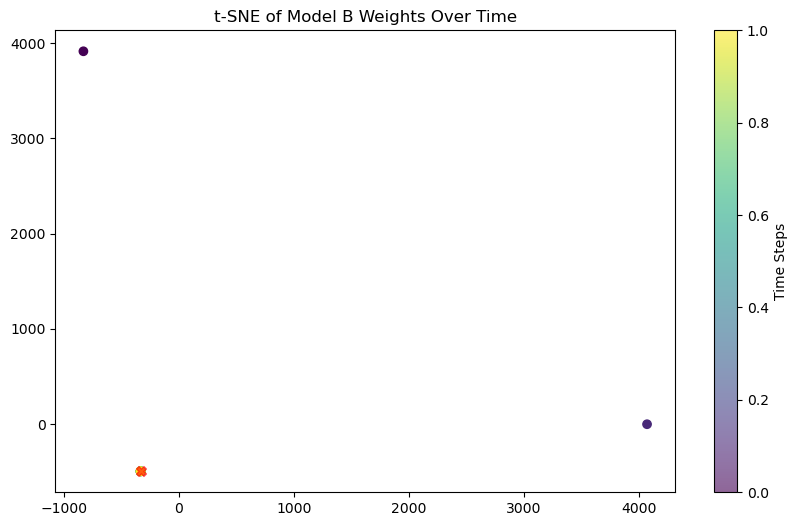

In [15]:
tsne_visualize(weights_over_time)

In [19]:
# Initialize Model C and its optimizer
model_C = SimpleNN()
optimizer_C = optim.SGD(model_C.parameters(), lr=0.01)
alpha = 0.1  # Weighting factor for alignment loss component

def weight_alignment_loss(model_A, model_C):
    loss = 0.0
    for (name_A, param_A), (name_C, param_C) in zip(model_A.named_parameters(), model_C.named_parameters()):
        # Check if the parameter is a weight matrix
        if 'weight' in name_A and 'weight' in name_C:
            # Compute Frobenius norm between Model C's weights and Model A's weights
            loss += torch.norm(param_A - param_C, p='fro')  # Frobenius norm for layer distance
    return loss

# Function to capture the flattened weights of a model
def get_flattened_weights(model):
    # Concatenate all weights into a single 1D array
    return np.concatenate([param.detach().view(-1).numpy() for param in model.parameters()])

# Training Model C with alignment and capturing weights over time
weights_over_time = []

def train_model_with_alignment_and_capture(model_C, model_A, dataloader, criterion, optimizer, alpha, epochs=2):
    model_C.train()
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model_C(inputs)
            
            # Calculate classification loss
            task_loss = criterion(outputs, targets)
            
            # Calculate alignment loss
            alignment_loss = weight_alignment_loss(model_A, model_C)
            
            # Combine losses
            loss = task_loss + alpha * alignment_loss
            loss.backward()
            optimizer.step()
        
        # Capture Model C's weights after each epoch
        weights_over_time.append(get_flattened_weights(model_C))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Task Loss: {task_loss.item():.4f}, Alignment Loss: {alignment_loss.item():.4f}")


In [21]:
# Train Model C and capture weights
train_model_with_alignment_and_capture(model_C, model_A, train_loader, criterion, optimizer_C, alpha=alpha, epochs=20)

# Add Model A's weights as a reference point
weights_over_time.append(get_flattened_weights(model_A))

Epoch [1/20], Loss: 1.7179, Task Loss: 0.6235, Alignment Loss: 10.9438
Epoch [2/20], Loss: 1.2046, Task Loss: 0.2495, Alignment Loss: 9.5517
Epoch [3/20], Loss: 1.1779, Task Loss: 0.3891, Alignment Loss: 7.8882
Epoch [4/20], Loss: 0.9058, Task Loss: 0.2980, Alignment Loss: 6.0774
Epoch [5/20], Loss: 0.6124, Task Loss: 0.1951, Alignment Loss: 4.1724
Epoch [6/20], Loss: 0.6486, Task Loss: 0.4260, Alignment Loss: 2.2265
Epoch [7/20], Loss: 0.3775, Task Loss: 0.3419, Alignment Loss: 0.3564
Epoch [8/20], Loss: 0.2468, Task Loss: 0.2418, Alignment Loss: 0.0501
Epoch [9/20], Loss: 0.1878, Task Loss: 0.1843, Alignment Loss: 0.0355
Epoch [10/20], Loss: 0.3652, Task Loss: 0.3620, Alignment Loss: 0.0316
Epoch [11/20], Loss: 0.3655, Task Loss: 0.3621, Alignment Loss: 0.0343
Epoch [12/20], Loss: 0.1311, Task Loss: 0.1279, Alignment Loss: 0.0315
Epoch [13/20], Loss: 0.1973, Task Loss: 0.1947, Alignment Loss: 0.0259
Epoch [14/20], Loss: 0.2318, Task Loss: 0.2286, Alignment Loss: 0.0324
Epoch [15/20],

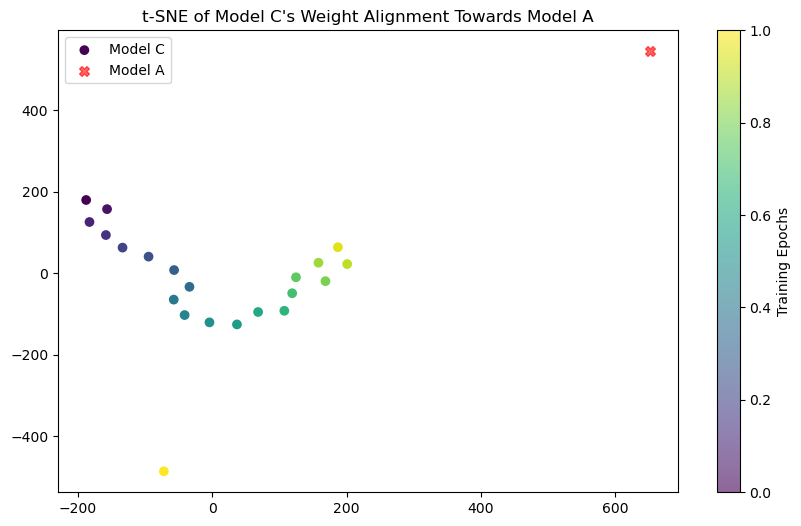

In [22]:
# Add Model A's weights as a reference point
weights_over_time.append(get_flattened_weights(model_A))

# Perform t-SNE visualization on captured weights
def tsne_visualize_alignment(weights_over_time):
    tsne = TSNE(n_components=2, perplexity=min(5, len(weights_over_time) - 1))
    tsne_data = np.array(weights_over_time)
    tsne_result = tsne.fit_transform(tsne_data)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_result[:-1, 0], tsne_result[:-1, 1], c=np.arange(len(weights_over_time) - 1), cmap='viridis', label="Model C")
    plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], c='red', label="Model A", marker="X", s=50, alpha = 0.6)  # Model A as red X
    plt.colorbar(label='Training Epochs')
    plt.legend()
    plt.title("t-SNE of Model C's Weight Alignment Towards Model A")
    plt.show()

# Run t-SNE visualization
tsne_visualize_alignment(weights_over_time)

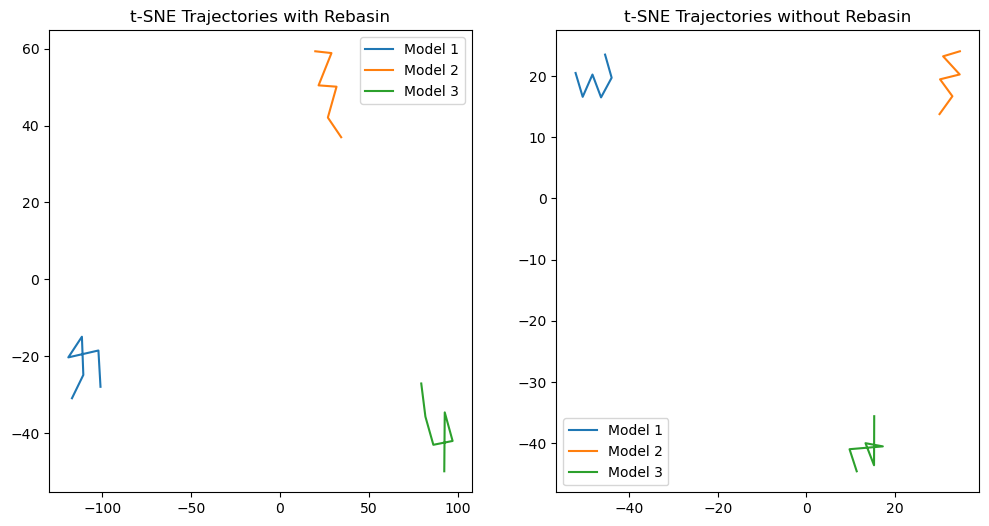

In [35]:
# Function to train model for a single epoch
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Define the models with different initializations
models = [SimpleNN() for _ in range(3)]
optimizers = [optim.SGD(model.parameters(), lr=0.01) for model in models]
criterion = nn.CrossEntropyLoss()

# Train each model for a few epochs
for model, optimizer in zip(models, optimizers):
    for _ in range(2):  # Train for 2 epochs
        train_one_epoch(model, train_loader, criterion, optimizer)

# Perform rebasin by aligning each model to the first model (reference model)
reference_model = models[0]

def approximate_weight_matching(model_A, model_B):
    """
    The weight-matching approach from Git Rebasin (algorithm 2). 
    A greedy coordinate descemt along permutation matricies of B w.r.t A
    where A and B are both weight sets of simple Neural Networks. 
    """
    for (name_A, param_A), (name_B, param_B) in zip(model_A.named_parameters(), model_B.named_parameters()):
        if 'weight' in name_A:
            distance_matrix = torch.cdist(param_A.T, param_B.T) # Distance between A and B
            row_ind, col_ind = torch.topk(-distance_matrix, k=16, dim=1) # Return the reverse order of A-B distance in A dims (16)
            sorted_B = torch.zeros_like(param_B) # Create placeholder B to repopulate
            for i, j in enumerate(col_ind[0]):
                sorted_B[:, i] = param_B[:, j] # Reshuffle B elements acording to greedy search in torch.topk()
            param_B.data = sorted_B

# Rebasin models to align with the reference model
for model in models[1:]:  # Skip the reference model itself
    approximate_weight_matching(reference_model, model)

# Function to capture weights
def get_flattened_weights(model):
    return np.concatenate([param.detach().view(-1).numpy() for param in model.parameters()])

# Continue training both rebasined and non-rebasined models and capture weights over time
weights_rebasin = [[] for _ in models]
weights_no_rebasin = [[] for _ in models]
optimizers_rebasin = [optim.SGD(model.parameters(), lr=0.01) for model in models]
optimizers_no_rebasin = [optim.SGD(model.parameters(), lr=0.01) for model in models]

# Capture initial weights
for i, model in enumerate(models):
    weights_rebasin[i].append(get_flattened_weights(model))
    weights_no_rebasin[i].append(get_flattened_weights(model))

# Train models with and without rebasin and capture weights over epochs
for epoch in range(5):
    # Train rebasined models
    for model, optimizer, weights in zip(models, optimizers_rebasin, weights_rebasin):
        train_one_epoch(model, train_loader, criterion, optimizer)
        weights.append(get_flattened_weights(model))

    # Train non-rebasined models
    for i, (model, optimizer) in enumerate(zip(models, optimizers_no_rebasin)):
        train_one_epoch(model, train_loader, criterion, optimizer)
        weights_no_rebasin[i].append(get_flattened_weights(model))

# Flatten all weights into a single array for t-SNE
all_weights_rebasin = np.array([w for weights in weights_rebasin for w in weights])
all_weights_no_rebasin = np.array([w for weights in weights_no_rebasin for w in weights])

# Run t-SNE on both rebasined and non-rebasined weights
tsne = TSNE(n_components=2, perplexity=5)
tsne_results_rebasin = tsne.fit_transform(all_weights_rebasin)
tsne_results_no_rebasin = tsne.fit_transform(all_weights_no_rebasin)

# Plotting
plt.figure(figsize=(12, 6))

# Plot rebasined models
plt.subplot(1, 2, 1)
for i in range(len(models)):
    indices = range(i * 6, (i + 1) * 6)  # 6 points per model (initial + 5 epochs)
    plt.plot(tsne_results_rebasin[indices, 0], tsne_results_rebasin[indices, 1], label=f'Model {i+1}')
plt.title("t-SNE Trajectories with Rebasin")
plt.legend()

# Plot non-rebasined models
plt.subplot(1, 2, 2)
for i in range(len(models)):
    indices = range(i * 6, (i + 1) * 6)
    plt.plot(tsne_results_no_rebasin[indices, 0], tsne_results_no_rebasin[indices, 1], label=f'Model {i+1}')
plt.title("t-SNE Trajectories without Rebasin")
plt.legend()

plt.show()


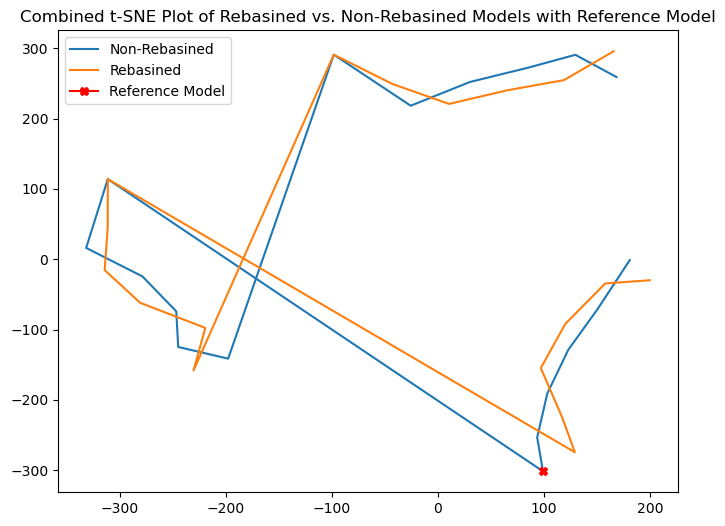

In [53]:
# Combine weights, adding the reference model only once
combined_weights = np.vstack([all_weights_rebasin[:-1], all_weights_no_rebasin[:-1], reference_weights[None, :]])
combined_labels = np.array(['Rebasined'] * (len(all_weights_rebasin) - 1) + 
                           ['Non-Rebasined'] * (len(all_weights_no_rebasin) - 1) + 
                           ['Reference'])

# Run t-SNE on the combined weights
tsne_results_combined = TSNE(n_components=2, perplexity=5).fit_transform(combined_weights)

# Plot combined t-SNE results
plt.figure(figsize=(8, 6))
for label in np.unique(combined_labels):
    indices = combined_labels == label
    if label == "Reference":
        plt.plot(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1], c='red', marker="X", label="Reference Model")
    else:
        plt.plot(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1], label=label)
plt.legend()
plt.title("Combined t-SNE Plot of Rebasined vs. Non-Rebasined Models with Reference Model")
plt.show()


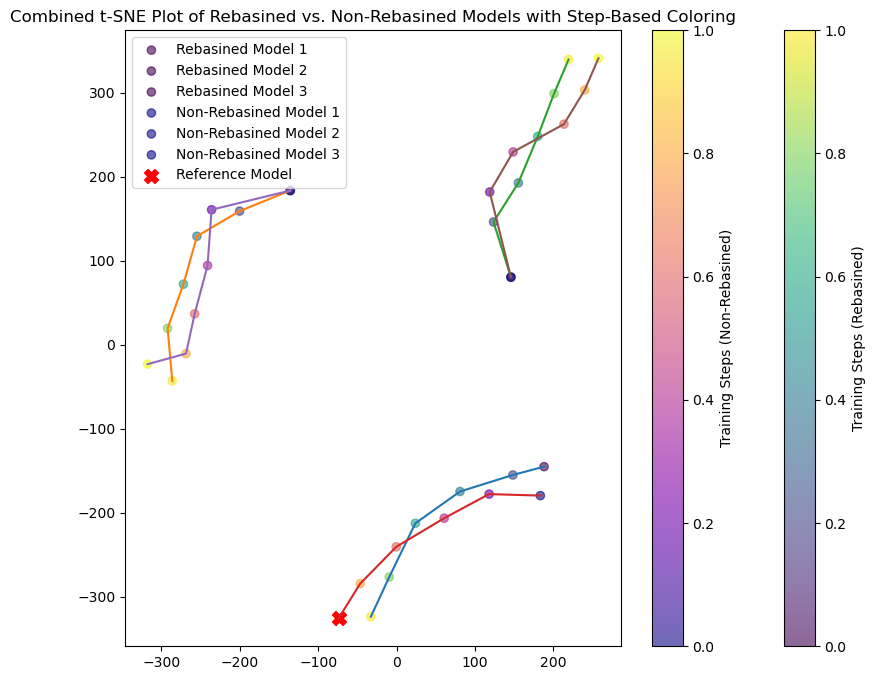

In [63]:
# Remove reference model before combining weights
all_weights_rebasin_no_ref = all_weights_rebasin[:-1]
all_weights_no_rebasin_no_ref = all_weights_no_rebasin[:-1]

# Combine weights, adding the reference model only once at the end
combined_weights = np.vstack([all_weights_rebasin_no_ref, all_weights_no_rebasin_no_ref, reference_weights[None, :]])
combined_labels = np.array(['Rebasined'] * len(all_weights_rebasin_no_ref) + 
                           ['Non-Rebasined'] * len(all_weights_no_rebasin_no_ref) + 
                           ['Reference'])

# Run t-SNE on the combined weights
tsne_results_combined = TSNE(n_components=2, perplexity=5).fit_transform(combined_weights)



# Plot combined t-SNE results
plt.figure(figsize=(10, 8))

# Define colors for rebasined and non-rebasined models
n_steps = len(all_weights_rebasin_no_ref) // len(models)  # Number of steps per model
cmap_rebasin = plt.cm.viridis
cmap_no_rebasin = plt.cm.plasma

# Plot rebasined models with training step coloring and color bar
sc_rebasin = None
for i in range(len(models)):
    indices = range(i * n_steps, (i + 1) * n_steps)  # Indices for each model's steps
    colors = np.linspace(0, 1, n_steps)
    sc_rebasin = plt.scatter(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1], 
                             c=colors, cmap=cmap_rebasin, label=f'Rebasined Model {i+1}', alpha=0.6)
    plt.plot(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1])

# Plot non-rebasined models with training step coloring and color bar
sc_no_rebasin = None
offset = len(all_weights_rebasin_no_ref)  # Offset for non-rebasined models in combined weights
for i in range(len(models)):
    indices = range(offset + i * n_steps, offset + (i + 1) * n_steps)
    colors = np.linspace(0, 1, n_steps)
    sc_no_rebasin = plt.scatter(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1], 
                                c=colors, cmap=cmap_no_rebasin, label=f'Non-Rebasined Model {i+1}', alpha=0.6)
    plt.plot(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1])

# Plot the reference model as a distinct marker
plt.scatter(tsne_results_combined[-1, 0], tsne_results_combined[-1, 1], c='red', marker="X", s=100, label="Reference Model")

# Add color bars for each set of models
cbar_rebasin = plt.colorbar(sc_rebasin, ax=plt.gca(), label="Training Steps (Rebasined)")
cbar_no_rebasin = plt.colorbar(sc_no_rebasin, ax=plt.gca(), label="Training Steps (Non-Rebasined)")

plt.legend()
plt.title("Combined t-SNE Plot of Rebasined vs. Non-Rebasined Models with Step-Based Coloring")
plt.show()


# Making this more robust: - W.I.P -

In [173]:
# Helper function to generate colors for each training step
def generate_step_colors(n_steps, cmap):
    return cmap(np.linspace(0, 1, n_steps))

# Plotting function for separated rebasined/non-rebasined trajectories
def plot_tsne_separated(tsne_data, tsne_reference, n_models, n_steps, rebasin=True):
    plt.figure(figsize=(8, 6))
    
    # Define color map
    cmap = cm.viridis if rebasin else cm.plasma
    
    # Plot each model's trajectory with step-based coloring
    for i in range(n_models):
        indices = range(i * n_steps, (i + 1) * n_steps)
        colors = generate_step_colors(n_steps, cmap)
        plt.scatter(tsne_data[indices, 0], tsne_data[indices, 1], label=f'Model {i+1}', alpha=0.6)
        plt.plot(tsne_data[indices, 0], tsne_data[indices, 1]) # new ish addition
    
    title = "t-SNE Trajectories with Rebasin" if rebasin else "t-SNE Trajectories without Rebasin"
    plt.scatter(tsne_reference[0], tsne_reference[1], c='red', marker="X", s=100, label="Reference Model")
    plt.title(title)
    # plt.colorbar(cm.ScalarMappable(cmap=cmap), label="Training Steps")
    plt.legend()
    plt.show()

# Example t-SNE run for arbitrary data
def run_tsne_and_plot(models_data, reference_model, n_models, n_steps):
    """
    !!! DEPRECIATED !!!
    
    Runs t-SNE and plots separate rebasin and non-rebasin t-SNE plots.
    models_data: list of model weights for rebasined and non-rebasined trajectories.
    reference_model: reference model weights for alignment
    n_models: number of models in each category
    n_steps: number of training steps (including initial)
    """
    # Prepare combined data for t-SNE
    rebasin_weights = np.vstack(models_data['rebasined'])
    non_rebasin_weights = np.vstack(models_data['non_rebasined'])
    combined_data = np.vstack([rebasin_weights, non_rebasin_weights, reference_model[None, :]])

    # Run t-SNE
    tsne_results = TSNE(n_components=2, perplexity=min(30, len(combined_data) - 1)).fit_transform(combined_data)

    # Separate t-SNE results for rebasined and non-rebasined
    tsne_rebasin = tsne_results[:len(rebasin_weights)]
    tsne_no_rebasin = tsne_results[len(rebasin_weights):len(rebasin_weights) + len(non_rebasin_weights)]
    tsne_reference = tsne_results[-1]

    # Plot rebasined and non-rebasined t-SNE plots separately
    plot_tsne_separated(tsne_rebasin, n_models, n_steps, rebasin=True)
    plot_tsne_separated(tsne_no_rebasin, n_models, n_steps, rebasin=False)
    
    # Combined plot with reference model for full view
    plt.figure(figsize=(10, 8))
    
    # Plot rebasined
    # cmap_rebasin = cm.viridis
    for i in range(n_models):
        indices = range(i * n_steps, (i + 1) * n_steps)
        colors = generate_step_colors(n_steps, cmap_rebasin)
        sc_rebasin = plt.scatter(tsne_rebasin[indices, 0], tsne_rebasin[indices, 1], label=f'Rebasined Model {i+1}', alpha=0.6)
        plt.plot(tsne_rebasin[indices, 0], tsne_rebasin[indices, 1])

        # cbar_rebasin = plt.colorbar(sc_rebasin, ax=plt.gca(), label="Training Steps (Rebasined)")


    # Plot non-rebasined
    # cmap_no_rebasin = cm.plasma
    offset = len(rebasin_weights)
    for i in range(n_models):
        indices = range(offset + i * n_steps, offset + (i + 1) * n_steps - 1)
        colors = generate_step_colors(n_steps, cmap_no_rebasin)
        sc_no_rebasin = plt.scatter(tsne_no_rebasin[indices, 0], tsne_no_rebasin[indices, 1], label=f'Non-Rebasined Model {i+1}', alpha=0.6)
        plt.plot(tsne_no_rebasin[indices, 0], tsne_no_rebasin[indices, 1])

        # cbar_no_rebasin = plt.colorbar(sc_no_rebasin, ax=plt.gca(), label="Training Steps (Non-Rebasined)")


    # Plot reference model
    plt.scatter(tsne_reference[0], tsne_reference[1], c='red', marker="X", s=100, label="Reference Model")
    plt.title("Combined t-SNE Plot of Rebasined vs. Non-Rebasined Models with Step-Based Coloring")
    plt.legend()
    plt.show()


# Example t-SNE run for arbitrary data
def compare_plots(models_data, reference_model, n_models, n_steps):
    """
    Runs t-SNE and plots separate rebasin and non-rebasin t-SNE plots.
    models_data: list of model weights for rebasined and non-rebasined trajectories.
    reference_model: reference model weights for alignment
    n_models: number of models in each category
    n_steps: number of training steps (including initial)
    """
    # Prepare combined data for t-SNE
    rebasin_weights = np.vstack(models_data['rebasined'])
    non_rebasin_weights = np.vstack(models_data['non_rebasined'])
    combined_data = np.vstack([rebasin_weights, non_rebasin_weights, reference_model[None, :]])

    # Run t-SNE
    tsne_results = TSNE(n_components=2, perplexity=min(30, len(combined_data) - 1)).fit_transform(combined_data)

    # Separate t-SNE results for rebasined and non-rebasined
    tsne_rebasin = tsne_results[:len(rebasin_weights)]
    tsne_no_rebasin = tsne_results[len(rebasin_weights):len(rebasin_weights) + len(non_rebasin_weights)]
    tsne_reference = tsne_results[-1]

    # Plot rebasined and non-rebasined t-SNE plots separately
    plot_tsne_separated(tsne_rebasin, tsne_reference, n_models, n_steps, rebasin=True)
    plot_tsne_separated(tsne_no_rebasin, tsne_reference, n_models, n_steps, rebasin=False)


In [175]:
# Example: Generate mock data for 4 models, each trained over 7 epochs (steps) post-rebasin
n_models = 4
n_steps = 7

# Mock weight data generation
def generate_mock_weights(n_models, n_steps, dim=100):
    return [np.random.randn(n_steps, dim) for _ in range(n_models)]

# Generate rebasined and non-rebasined mock data
rebasined_data = generate_mock_weights(n_models, n_steps)
non_rebasined_data = generate_mock_weights(n_models, n_steps)

# Mock reference model weights
reference_weights = np.random.randn(100)

# Organize data as expected by the plotting function
models_data = {
    'rebasined': rebasined_data,
    'non_rebasined': non_rebasined_data
}

# Run t-SNE and plot
# run_tsne_and_plot(models_data, reference_weights, n_models, n_steps)

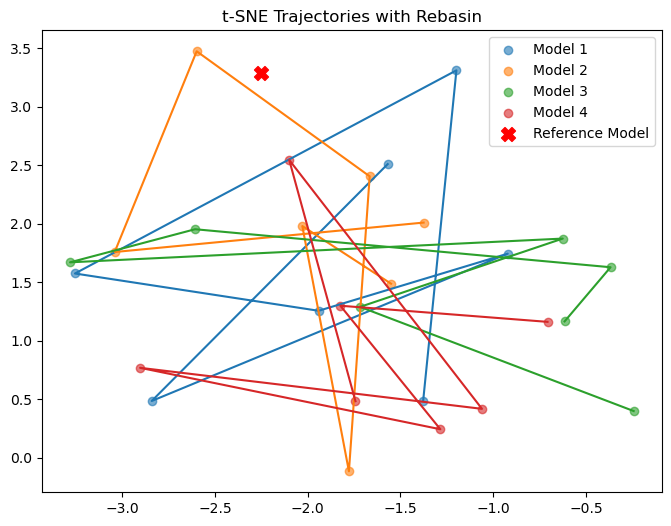

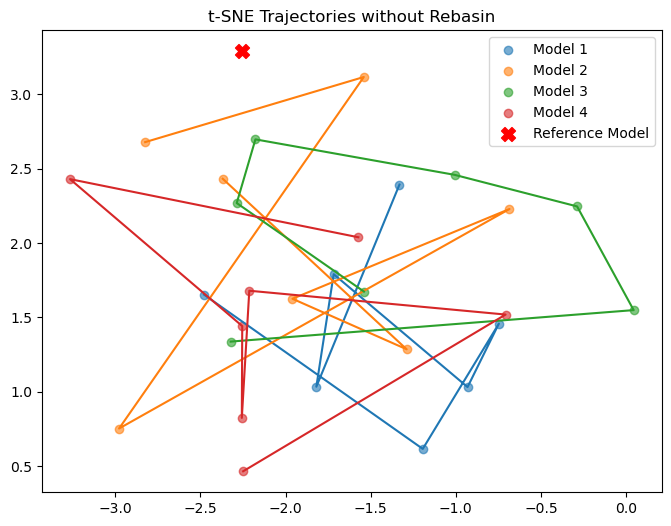

In [177]:
compare_plots(models_data, reference_weights, n_models, n_steps)

## Train more models and apply plotting functions

In [269]:
n_models = 3
n_steps = 12
init_steps = 0

# Function to initialize weights with normal distribution and random scaling
def custom_weight_init(model, scale_factor):
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Initialize with standard normal and apply random scaling factor
            nn.init.normal_(param, mean=0, std=1)
            param.data *= scale_factor
        elif 'bias' in name:
            # Initialize biases with zeros
            nn.init.zeros_(param)

# Create models with different scaling factors
scales = [np.exp(np.random.uniform(-n_models, n_models)) for _ in range(n_models)]  # Exponential scale between e^-2 and e^2

# Define the models with different initializations
models = [SimpleNN() for _ in range(n_models)]
optimizers = [optim.SGD(model.parameters(), lr=0.01) for model in models]
criterion = nn.CrossEntropyLoss()


# Apply custom initialization to each model
for model, scale in zip(models, scales):
    custom_weight_init(model, scale)


# Train each model for a few epochs
for model, optimizer in zip(models, optimizers):
    for _ in range(init_steps):  # Train for 2 epochs
        train_one_epoch(model, train_loader, criterion, optimizer)

# Perform rebasin by aligning each model to the first model (reference model)
reference_model = models[0]

# Rebasin models to align with the reference model
for model in models[1:]:  # Skip the reference model itself
    approximate_weight_matching(reference_model, model)

# Continue training both rebasined and non-rebasined models and capture weights over time
weights_rebasin = [[] for _ in models]
weights_no_rebasin = [[] for _ in models]
optimizers_rebasin = [optim.SGD(model.parameters(), lr=0.01) for model in models]
optimizers_no_rebasin = [optim.SGD(model.parameters(), lr=0.01) for model in models]

# Capture initial weights
for i, model in enumerate(models):
    weights_rebasin[i].append(get_flattened_weights(model))
    weights_no_rebasin[i].append(get_flattened_weights(model))

# Train models with and without rebasin and capture weights over epochs
for epoch in range(n_steps):
    # Train rebasined models
    for model, optimizer, weights in zip(models, optimizers_rebasin, weights_rebasin):
        train_one_epoch(model, train_loader, criterion, optimizer)
        weights.append(get_flattened_weights(model))

    # Train non-rebasined models
    for i, (model, optimizer) in enumerate(zip(models, optimizers_no_rebasin)):
        train_one_epoch(model, train_loader, criterion, optimizer)
        weights_no_rebasin[i].append(get_flattened_weights(model))


In [270]:
# Flatten all weights into a single array for t-SNE
rebasined_data = np.array([w for weights in weights_rebasin for w in weights])
non_rebasined_data = np.array([w for weights in weights_no_rebasin for w in weights])

# Mock reference model weights
reference_weights = get_flattened_weights(reference_model)

# Organize data as expected by the plotting function
models_data = {
    'rebasined': rebasined_data,
    'non_rebasined': non_rebasined_data
}

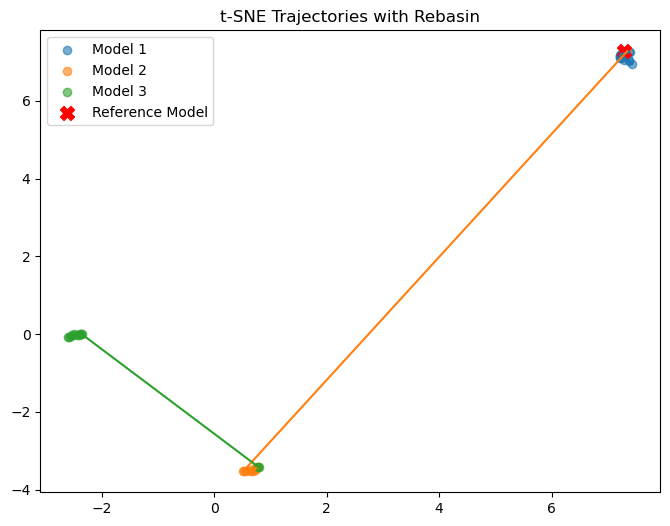

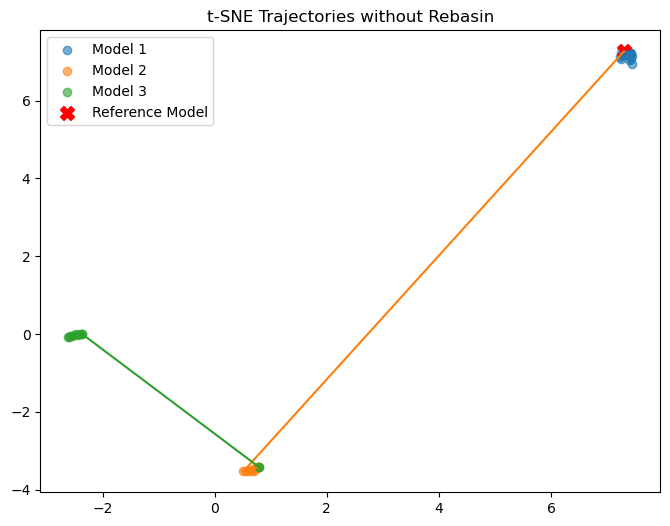

In [271]:
compare_plots(models_data, reference_weights, n_models, n_steps)

In [272]:

combined_data = np.vstack([rebasined_data, non_rebasined_data, reference_weights])

# Run t-SNE
tsne_data = TSNE(n_components=2, perplexity=min(30, len(combined_data) - 1)).fit_transform(combined_data)


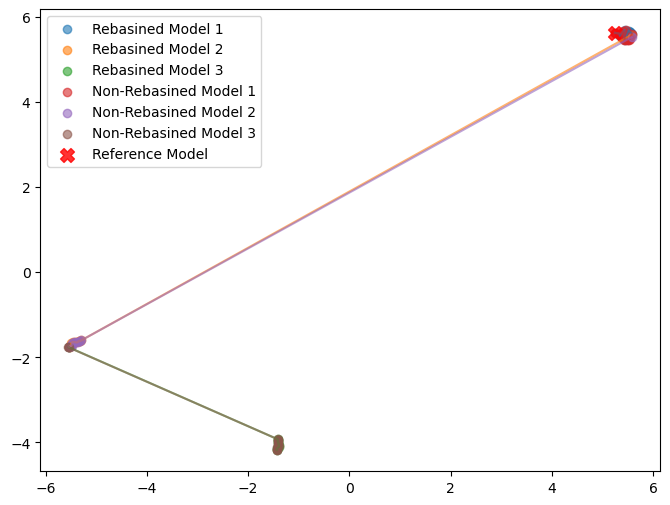

In [273]:
plt.figure(figsize=(8, 6))

# # Define color map
# # cmap = cm.viridis if rebasin else cm.plasma

# # Plot each model's trajectory with step-based coloring
for i in range(n_models):
    indices = range(i * n_steps, (i + 1) * n_steps)
    # colors = generate_step_colors(n_steps, cmap)
    plt.scatter(tsne_data[indices, 0], tsne_data[indices, 1], label=f"Rebasined Model {i+1}", alpha=0.6)
    plt.plot(tsne_data[indices, 0], tsne_data[indices, 1], alpha = 0.6) # new ish addition
    # plt.text(tsne_data[indices, 0], tsne_data[indices, 1], f"Step {i+1}", fontsize=9)

offset = len(rebasined_data)
for i in range(n_models):
    indices = range(offset + i * n_steps, offset + (i + 1) * n_steps)
    # colors = generate_step_colors(n_steps, cmap_no_rebasin)
    plt.scatter(tsne_data[indices, 0], tsne_data[indices, 1], label=f'Non-Rebasined Model {i+1}', alpha=0.6)
    plt.plot(tsne_data[indices, 0], tsne_data[indices, 1], alpha = 0.6)

# title = "t-SNE Trajectories with Rebasin" if rebasin else "t-SNE Trajectories without Rebasin"
plt.scatter(tsne_data[0, 0], tsne_data[0, 1], c='red', marker="X", s=100, alpha = 0.8, label="Reference Model")
# plt.title(title)
# plt.colorbar(cm.ScalarMappable(cmap=cmap), label="Training Steps")
plt.legend()
plt.show()

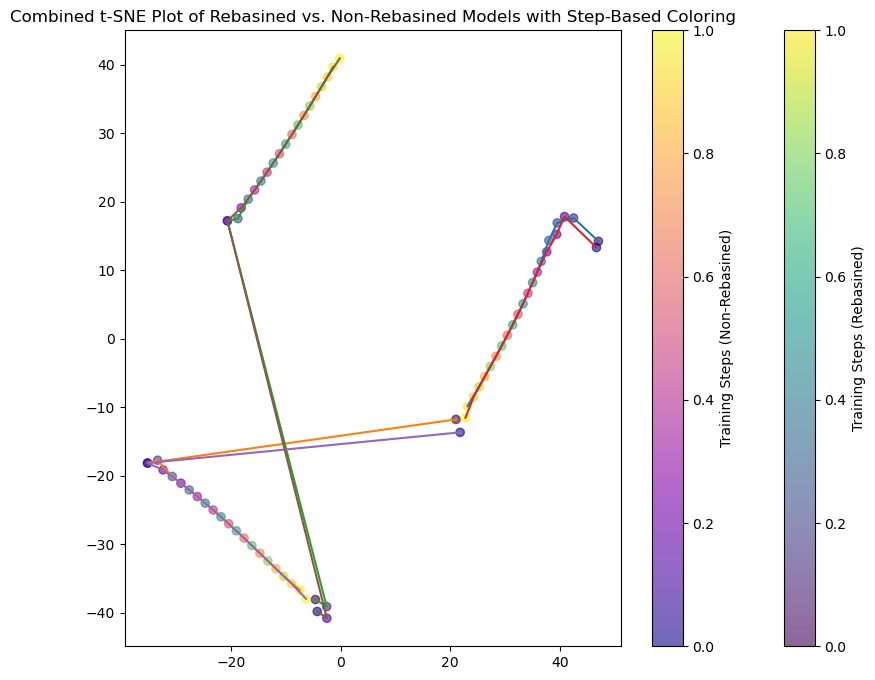

In [274]:
# Remove reference model before combining weights
all_weights_rebasin_no_ref = rebasined_data[:-1]
all_weights_no_rebasin_no_ref = non_rebasined_data[:-1]

# Combine weights, adding the reference model only once at the end
combined_weights = np.vstack([all_weights_rebasin_no_ref, all_weights_no_rebasin_no_ref, reference_weights[None, :]])
combined_labels = np.array(['Rebasined'] * len(all_weights_rebasin_no_ref) + 
                           ['Non-Rebasined'] * len(all_weights_no_rebasin_no_ref) + 
                           ['Reference'])

# Run t-SNE on the combined weights
tsne_results_combined = TSNE(n_components=2, perplexity=5).fit_transform(combined_weights)



# Plot combined t-SNE results
plt.figure(figsize=(10, 8))

# Define colors for rebasined and non-rebasined models
n_steps = len(all_weights_rebasin_no_ref) // len(models)  # Number of steps per model
cmap_rebasin = plt.cm.viridis
cmap_no_rebasin = plt.cm.plasma

# Plot rebasined models with training step coloring and color bar
sc_rebasin = None
for i in range(len(models)):
    indices = range(i * n_steps, (i + 1) * n_steps)  # Indices for each model's steps
    colors = np.linspace(0, 1, n_steps)
    sc_rebasin = plt.scatter(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1], 
                             c=colors, cmap=cmap_rebasin, label=f'Rebasined Model {i+1}', alpha=0.6)
    plt.plot(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1])

# Plot non-rebasined models with training step coloring and color bar
sc_no_rebasin = None
offset = len(all_weights_rebasin_no_ref)  # Offset for non-rebasined models in combined weights
for i in range(len(models)):
    indices = range(offset + i * n_steps, offset + (i + 1) * n_steps)
    colors = np.linspace(0, 1, n_steps)
    sc_no_rebasin = plt.scatter(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1], 
                                c=colors, cmap=cmap_no_rebasin, label=f'Non-Rebasined Model {i+1}', alpha=0.6)
    plt.plot(tsne_results_combined[indices, 0], tsne_results_combined[indices, 1])

# Plot the reference model as a distinct marker
# plt.scatter(tsne_results_combined[-1, 0], tsne_results_combined[-1, 1], c='red', marker="X", s=100, label="Reference Model")

# Add color bars for each set of models
cbar_rebasin = plt.colorbar(sc_rebasin, ax=plt.gca(), label="Training Steps (Rebasined)")
cbar_no_rebasin = plt.colorbar(sc_no_rebasin, ax=plt.gca(), label="Training Steps (Non-Rebasined)")

# plt.legend()
plt.title("Combined t-SNE Plot of Rebasined vs. Non-Rebasined Models with Step-Based Coloring")
plt.show()
